# Neighborhood Project

## CMPINF0999 Final

### Yifeng Qiu and James Fenn

## Introduction

Using the datasets from the WPRDC, our task was to narrow down the huge amount of neighborhoods within Pittsburgh to a single "best" neighborhood to live in. However, we weren't quite sure where to start with the huge amount of data being given to us, so we decided to use the data to determine what aspect of each neighborhood was the most annoying to the people living there. How would we determine that? By using the 311 dataset, which contains a column defining each type of report that has been filed. If we find the most common type of report in each neighborhood, that is probably the most annoying aspect of it, and the most likely reason that someone would decide not to live there.

## The Metric

Throughout the project, we used the following datasets:

  - [311 data](https://data.wprdc.org/dataset/311-data)
  - [Tree data](https://data.wprdc.org/dataset/city-trees)
  - [Right of Way Permits data](https://data.wprdc.org/dataset/right-of-way-permits)
  
Each graph is accompanied by a description as well as inline comments describing how the data was generated using Python.

In [1]:
# load libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# basic arrest / "people" data; may depend on population of each neighborhood, unreliable unless scaled accordingly

# download 311 data from https://data.wprdc.org/dataset/311-data
data311 = pd.read_csv("https://data.wprdc.org/datastore/dump/76fda9d0-69be-4dd5-8108-0de7907fc5a4", low_memory=False)

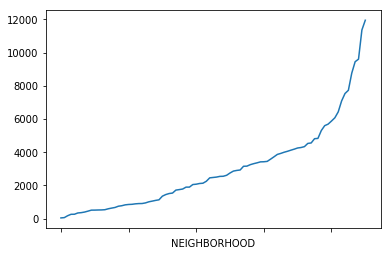

In [3]:
# plot amount of 311 calls per neighborhood in a line
data311.groupby("NEIGHBORHOOD").size().sort_values().plot(kind='line')

This shows us that _most_ neighborhoods get less than 6,000 calls, while there are just a few outliers going up to 12,000. We might want to stay away from these neighborhoods... or do we? The amount of 311 calls that each neighborhood recieves are likely dependent upon how many people are in that neighborhood or how big the neighborhood is.

In [4]:
# create DataFrame of quantity 311 calls indexed by neighborhood
mData311 = pd.DataFrame(data311.groupby("NEIGHBORHOOD").size(), columns=["calls"])
# add "mostType" column containing the most common request type of each neighborhood
mData311["mostType"] = data311.groupby(["NEIGHBORHOOD"]).agg(lambda x: x["REQUEST_TYPE"].value_counts().index[0])["REQUEST_TYPE"]

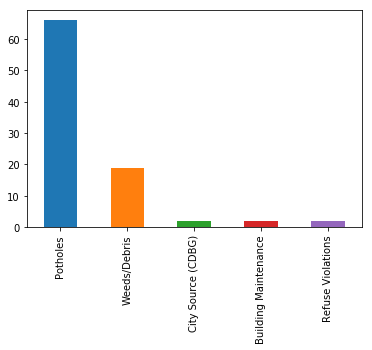

In [5]:
# plot the most common "most reported" request types
mData311["mostType"].value_counts().plot(kind='bar')

This shows us that the most common 311 calls are for potholes and Weed/Debris. We can use this to show that the most significant aspect of Pittsburgh neighborhoods that people find annoying are the potholes. In this case, to "narrow down" our list of potential best neighborhoods, we can look for a set of neighborhoods with the least amount of potholes.

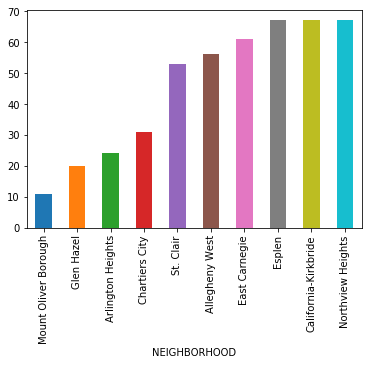

In [6]:
# create a new column containing the amount of pothole reports
mData311["potholes"] = data311.groupby(["NEIGHBORHOOD"]).agg(lambda x: len(x.loc[x["REQUEST_TYPE"] == "Potholes"]))["REQUEST_TYPE"]
# sort by potholes column, get smallest 10 neighborhoods, and graph
mData311["potholes"].sort_values(ascending=True).head(10).plot(kind='bar')

This data seems to indicate that Mount Oliver Borough has the least amount of potholes, however this data could easily be influenced by the size of the neighborhood. For all I know, Mount Oliver Borough could contain a single road that has 10 potholes on it. That wouldn't be a very good neighborhood compared to, say Esplen, which could have 68 potholes spread out over 200 roads. Similar to the initial line graph of the total amount of calls, let's graph the amount of pothole calls over all of the neigborhoods.

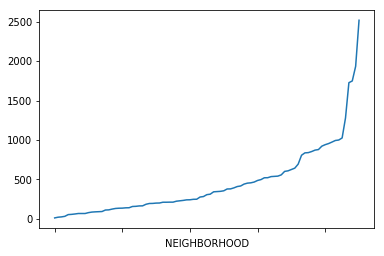

In [7]:
mData311["potholes"].sort_values(ascending=True).plot(kind='line')

This graph seems similar to the initial graph of the quantity of all 311 calls per neighborhood, but it isn't quite the same. Instead of measuring only the quantity of pothole reports per neighborhood, it might yield more accurate results to scale them based on the total reports in that neighborhood; in other words, find the neighborhood in which the percentage of pothole reports is the least.

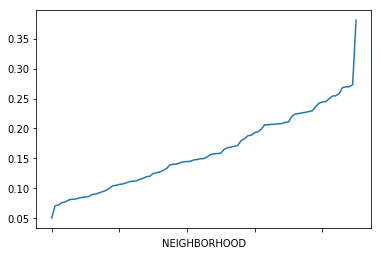

In [8]:
# create a new column, "potholePercentage", containing the percentage of the reports in each neighborhood that are potholes
mData311["potholePercentage"] = data311.groupby(["NEIGHBORHOOD"]).agg(lambda x: len(x.loc[x["REQUEST_TYPE"] == "Potholes"]) / len(x))["REQUEST_TYPE"]
# graph the result
mData311["potholePercentage"].sort_values(ascending=True).plot(kind='line')

Now **this** graph looks a little more linear. This we can use. Let's get the neighborhoods for which less than 10% of the reports are about potholes.

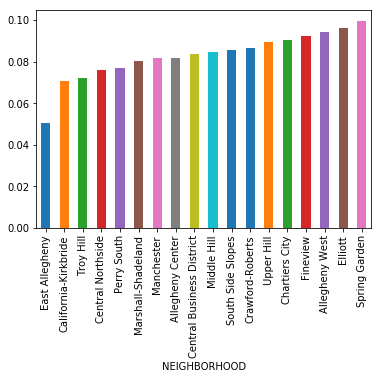

In [9]:
mData311["potholePercentage"].sort_values(ascending=True).loc[mData311["potholePercentage"] < 0.1].plot(kind='bar')

This has given us a more accurate list of the neighborhoods with the least _percentage_ of potholes, as opposed to quantity. It may not be perfectly accurate, as the total amount of reports doesn't necessarily indicate the size of the neighborhood, and a lack of pothole reports may indicate that other types of reports are more prevalent, but it can at least get us on the right track. Let's take our selection of the "best" neighborhoods from this criteria and measure them against some other attributes.

In [10]:
# information about the environment / physical aspects of each neighborhood
# how many playgrounds are there, how many trees there are, what the air quality is, etc

# download trees data from https://data.wprdc.org/dataset/city-trees
dataTrees = pd.read_csv("https://data.wprdc.org/datastore/dump/1515a93c-73e3-4425-9b35-1cd11b2196da", low_memory=False)

Let's assume that a neighborhood is better if it has more trees. At this point we are completely disregarding the size of the neighborhood. Hopefully it won't have much effect on the result.

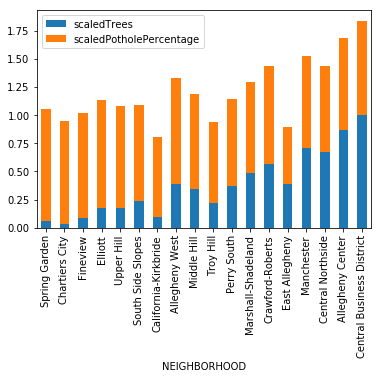

In [11]:
# take the neighborhoods with less than 10% pothole reports to measure against trees
mDataTrees = mData311.loc[mData311["potholePercentage"] < 0.1].copy()
# measure the quantity of trees in each neighborhood
mDataTrees["trees"] = dataTrees.loc[dataTrees["neighborhood"].isin(mDataTrees.index)].groupby(["neighborhood"]).agg(lambda x: len(x))["id"]
# scale the values equally from 0-1
mDataTrees["scaledPotholePercentage"] = mDataTrees["potholePercentage"] / mDataTrees["potholePercentage"].sort_values(ascending=False)[0]
mDataTrees["scaledTrees"] = mDataTrees["trees"] / mDataTrees["trees"].sort_values(ascending=False)[0]
# add "rank" column consisting of the trees (good) minus the potholes (bad)
mDataTrees["rank"] = mDataTrees["scaledTrees"] - mDataTrees["scaledPotholePercentage"]
# output tree quantity and pothole percentage side by side
mDataTrees.sort_values("rank")[["scaledTrees", "scaledPotholePercentage"]].plot(kind='bar', stacked=True)

Based on this data, the Central Business District has the best tree-to-pothole ratio, making it the best neighborhood by this measurement. East Allegheny, which _was_ winning in the initial pothole measurement, lost here because it has a smaller amount of trees, so it is likely that another factor was affecting it. However, as you can see, our measurements are a little flawed; it is true that the Central Business District does have the fewest potholes and the most trees, but it is also the Central Business District - I wouldn't exactly want to _live_ there. So let's try to apply a few other measurements to filter things like this out.

The most annoying thing that I can think about living in the Central Business District would be the amount of people. So many people in one place every day is bound to get in the way... so it could be beneficial to rank the neighborhoods using the right of way permits; the amount of obstructions to the right of way; roadworks and so on.

In [12]:
# data from https://data.wprdc.org/dataset/right-of-way-permits
dataParks = pd.read_csv("https://data.wprdc.org/datastore/dump/cc17ee69-b4c8-4b0c-8059-23af341c9214", low_memory=False)

Since this data is similar to the amount of trees, let's multiply the two values instead of simply combining them. This should prioritize how many of the trees are actually in a park, rather than just trees planted at the side of a road.

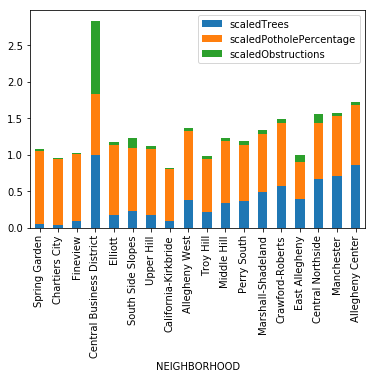

In [13]:
# copy existing neighborhood data
mDataParks = mDataTrees.copy()
# create a new column, "parks", with the quantity of parks per neighborhood
mDataParks["obstructions"] = dataParks.loc[dataParks["neighborhood"].isin(mDataParks.index)].groupby(["neighborhood"]).agg(lambda x: len(x))["id"]
# replace nonexistent data (neighborhoods that don't contain any parks) with zeros
mDataParks.fillna(0)
# scale amount of obstructions from 0-1
mDataParks["scaledObstructions"] = mDataParks["obstructions"] / mDataParks["obstructions"].sort_values(ascending=False)[0]
# update rank values to trees (good) - potholes (bad) - obstructions (bad)
mDataParks["rank"] = mDataParks["scaledTrees"] - mDataParks["scaledPotholePercentage"] - mDataParks["scaledObstructions"]
# graph all values together
mDataParks.sort_values("rank")[["scaledTrees", "scaledPotholePercentage", "scaledObstructions"]].plot(kind='bar', stacked=True)

## The Best Neighborhood

We believe that a good neighborhood needs to make people feel comfortable living there, so we checked the problem reports and found out that the potholes are a huge problem that bothering people. Thus, we decided to find out the neighborhood with the least amount of potholes. There are also many other factors impacting the research, for example, the size and the population of the neighborhoods. Well, we made the research based on the same ratio of the population and the size of the neighborhood. In addition, there is no point for us to say the least amount of potholes makes a neighborhood “the best neighborhood” since that’s actually the “least amount of potholes neighborhood”, so we added in another significant factor: trees. If a neighborhood has less potholes and more trees, we have the confidence to announce that. We used “311” databases and “trees” databases to find out the best neighborhood in Pittsburgh. 

However, we found that this data alone went against our expectations and showed the Central Business District - the busiest and most noisy part of Pittsburgh - to be the best neighborhood. This was completely accurate given the data we had chosen to use - the Central Business District does indeed have the smallest amount of potholes and the most trees - but that wasn't what we were looking for. In order to make our analysis a little more accurate, we decided to use the "Right of Way Permits" dataset alongside our existing data to also rank our neighborhoods based on the amount of "things happening" in each neighborhood that might get in a person's way. With this additional data, we determined the Allegheny Center to be the best neighborhood in Pittsburgh, as you can see in the graph above.

## Conclusion(s)

### Ethan

I believe that our function and the calculation were basically very good and fair for al the neighborhood in Pittsburgh, and the most important part of the research for us is to find the top significant factor of the neighborhood, so I am very glad that we had a good teamwork and same opinion about the factor "potholes" and "trees". It is a very meaningful research that not only let people understand and know about the best neighborhood in Pittsburgh, but also makes us think about the importance of the factors that what poeple and citizens really care about in a neighborhood.

### James

I was overall satisfied with the end result of Allegheny Center being the "best" neighborhood as it contains several interesting attractions such as the National Aviary and the Children's Museum of Pittsburgh. However, I feel like our data was still a little biased towards "public areas" over "living places", as there aren't actually many houses there, and I feel like there would still be too many people for it to be comfortable as a place to live. There isn't much we can do to change that, though.